<a href="https://colab.research.google.com/github/YannickPezeu/Titanic-Competition/blob/main/Titanic2_Deep_Learning_Best_Params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 16)
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
full_df = pd.concat([train_df, test_df], axis = 0, ignore_index = True)
full_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Preprocess

In [ ]:
train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")

def same_last_name_survived_relative(lastname, name):
  result = 0
  for lastname_other, name_other, survived in zip(list(train_df["Last_name"]), list(train_df["Name"]), list(train_df["Survived"])):
    if lastname_other == lastname and name_other != name and survived == 1:
      result += 1
    elif lastname_other == lastname and name_other != name and survived == 0:
      result -= 1
  return result

def same_cabin_survived_relative(cabin, name):
  result = 0
  for cabin_other, name_other, survived in zip(list(train_df["Cabin"]), list(train_df["Name"]), list(train_df["Survived"])):
    if cabin_other == cabin and name_other != name and survived == 1 and cabin != "0":
      result +=1
    elif cabin_other == cabin and name_other != name and survived == 0 and cabin != "0":
      result -=1
  return result

def preprocess(df):
  df["family_members"] = df["Parch"] + df["SibSp"]
  df["Last_name"] = df["Name"].str.extract(r"(^.*),")
  df["Title"] = df["Name"].str.extract(r"^.*, ([\w ]*)\.*")
  df["Cabin"].fillna("0", inplace = True)
  df = df[df["Title"] != "Capt"]
  if "PassengerId" in df.columns:
    df.drop("PassengerId", axis = 1, inplace = True)
  if "Ticket" in df.columns:
    df.drop("Ticket", axis = 1, inplace = True)

  def rare_title(x):
    if df["Title"].value_counts()[x] < 10:
      return "Rare"
    else:
      return x

  df["Title"] = df["Title"].map(rare_title)
  df["Title + sex + Pclass"] = df["Title"] + " " + df["Sex"] + " " + df["Pclass"].astype("string")
  # df.drop("Pclass", axis = 1, inplace = True)
  # df.drop("Sex", axis = 1, inplace = True)
  # df.drop("Title", axis = 1, inplace = True)
  df["Cabin_letter"] = df["Cabin"].str.extract(r"^([A-Z])")
  df["Cabin_letter"].fillna("0", inplace = True)
  df["Is_Baby"] = df["Age"].apply(lambda x: 1 if x <= 6 else 0)
  # df["Age_binned"] = pd.cut(df["Age"], [0,6,20,30,50,100])
  df["Fare_binned"] = pd.cut(df["Fare"], [0,10,50,80,1900])
  df["Age"].fillna(30.0, inplace = True)
  #####
  df["same_last_name_survived_relative"] = 0
  df["same_cabin_survived_relative"] = 0

  for index, row in df.iterrows():
    df.loc[index, "same_last_name_survived_relative"] = same_last_name_survived_relative(row["Last_name"], row["Name"])
    df.loc[index, "same_cabin_survived_relative"] = same_cabin_survived_relative(row["Cabin"], row["Name"])

  for col in ["Embarked","Last_name", "Title + sex + Pclass", "Parch", 
              "Cabin_letter", "Fare_binned", 
              "same_last_name_survived_relative", 
              "same_cabin_survived_relative", "Sex", "Pclass", "Title"]:
    df = pd.concat([df, pd.get_dummies(data = df[col], prefix = col + "_")], axis = 1)

  return df

full_df = pd.concat([train_df, test_df], axis = 0, ignore_index = True)
train_df = preprocess(train_df)
test_df = preprocess(test_df)
full_df = preprocess(full_df)


for col in ["Embarked","Last_name", "Title + sex + Pclass", "Parch", 
              "Cabin_letter", "Fare_binned", 
              "same_last_name_survived_relative", 
              "same_cabin_survived_relative", "Sex", "Pclass", "Title"]:
  full_df.drop(col, axis = 1, inplace = True)

# train_df.drop("Name", axis = 1, inplace = True)
# test_df.drop("Name", axis = 1, inplace = True)
# train_df.drop("Cabin", axis = 1, inplace = True)
# test_df.drop("Cabin", axis = 1, inplace = True)
full_df.drop("Name", axis = 1, inplace = True)
full_df.drop("Cabin", axis = 1, inplace = True)

train_df = full_df[0:len(train_df)]
test_df = full_df[len(train_df):len(train_df)+1+len(test_df)]
test_df["Fare"].fillna(np.mean(test_df["Fare"]), inplace = True)
train_df.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,Survived,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Last_name__Abbing,Last_name__Abbott,Last_name__Abelseth,Last_name__Abelson,Last_name__Abrahamsson,Last_name__Abrahim,Last_name__Adahl,Last_name__Adams,Last_name__Ahlin,Last_name__Aks,Last_name__Albimona,Last_name__Aldworth,Last_name__Alexander,Last_name__Alhomaki,Last_name__Ali,Last_name__Allen,Last_name__Allison,Last_name__Allum,Last_name__Andersen,Last_name__Andersen-Jensen,Last_name__Anderson,Last_name__Andersson,Last_name__Andreasson,Last_name__Andrew,Last_name__Andrews,Last_name__Angheloff,Last_name__Angle,Last_name__Appleton,Last_name__Arnold-Franchi,Last_name__Aronsson,Last_name__Artagaveytia,...,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3,Sex__female,Sex__male,Pclass__1,Pclass__2,Pclass__3,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
0,0.0,22.0,1,7.2500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,1.0,38.0,1,71.2833,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
2,1.0,26.0,0,7.9250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,1.0,35.0,1,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0.0,35.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


# Exploration

In [ ]:
train_df

,Survived,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Last_name__Abbing,Last_name__Abbott,Last_name__Abelseth,Last_name__Abelson,Last_name__Abrahamsson,Last_name__Abrahim,Last_name__Adahl,Last_name__Adams,Last_name__Ahlin,Last_name__Aks,Last_name__Albimona,Last_name__Aldworth,Last_name__Alexander,Last_name__Alhomaki,Last_name__Ali,Last_name__Allen,Last_name__Allison,Last_name__Allum,Last_name__Andersen,Last_name__Andersen-Jensen,Last_name__Anderson,Last_name__Andersson,Last_name__Andreasson,Last_name__Andrew,Last_name__Andrews,Last_name__Angheloff,Last_name__Angle,Last_name__Appleton,Last_name__Arnold-Franchi,Last_name__Aronsson,Last_name__Artagaveytia,...,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3,Sex__female,Sex__male,Pclass__1,Pclass__2,Pclass__3,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
0,0.0,22.0,1,7.2500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,1.0,38.0,1,71.2833,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
2,1.0,26.0,0,7.9250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,1.0,35.0,1,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0.0,35.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,27.0,0,13.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
887,1.0,19.0,0,30.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
888,0.0,30.0,1,23.4500,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
889,1.0,26.0,0,30.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0


In [ ]:
print(train_df["same_cabin_survived_relative"].value_counts())
print(test_df["same_cabin_survived_relative"].value_counts())


KeyError: ignored

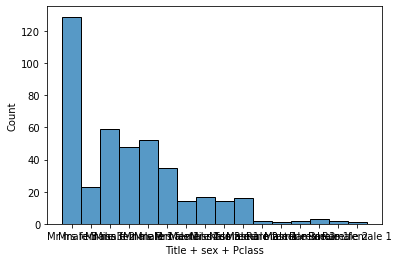

In [ ]:
ax = sns.histplot(test_df["Title + sex + Pclass"])


In [ ]:
test_df

,Survived,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Title + sex + Pclass__Master male 1,Title + sex + Pclass__Master male 2,Title + sex + Pclass__Master male 3,Title + sex + Pclass__Miss female 1,Title + sex + Pclass__Miss female 2,Title + sex + Pclass__Miss female 3,Title + sex + Pclass__Mr male 1,Title + sex + Pclass__Mr male 2,Title + sex + Pclass__Mr male 3,Title + sex + Pclass__Mrs female 1,Title + sex + Pclass__Mrs female 2,Title + sex + Pclass__Mrs female 3,Title + sex + Pclass__Rare female 1,Title + sex + Pclass__Rare female 2,Title + sex + Pclass__Rare female 3,Title + sex + Pclass__Rare male 1,Title + sex + Pclass__Rare male 2,Parch__0,Parch__1,Parch__2,Parch__3,Parch__4,Parch__5,Parch__6,Parch__9,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-276,same_cabin_survived_relative__-275,same_cabin_survived_relative__-274,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3
891,NaN,34.5,0,7.8292,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
892,NaN,47.0,1,7.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
893,NaN,62.0,0,9.6875,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
894,NaN,27.0,0,8.6625,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
895,NaN,22.0,1,12.2875,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,30.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1305,NaN,39.0,0,108.9000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1306,NaN,38.5,0,7.2500,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1307,NaN,30.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


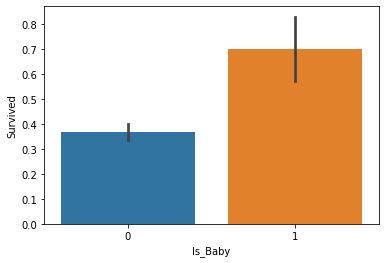

In [ ]:
sns.barplot(train_df["Is_Baby"], train_df["Survived"])

In [ ]:
# def same_cabin_died(cabin, name):
#   result = 0
#   for cabin_other, name_other, survived in zip(list(train_df["Cabin"]), list(train_df["Name"]), list(train_df["Survived"])):
#     if cabin_other == cabin and name_other != name and survived == 0:
#       result += 1
#   return result

# def same_cabin_survived(cabin, name):
#   result = 0
#   for cabin_other, name_other, survived in zip(list(train_df["Cabin"]), list(train_df["Name"]), list(train_df["Survived"])):
#     if cabin_other == cabin and name_other != name and survived == 1:
#       result +=1
#   return result

def same_cabin_survived_relative(cabin, name):
  result = 0
  for cabin_other, name_other, survived in zip(list(train_df["Cabin"]), list(train_df["Name"]), list(train_df["Survived"])):
    if cabin_other == cabin and name_other != name and survived == 1:
      result +=1
    elif cabin_other == cabin and name_other != name and survived == 0:
      result -=1
  return result

# train_df["same_cabin_died"] = 0
# train_df["same_cabin_survived"] = 0
train_df["same_cabin_survived_relative"] = 0
test_df["same_cabin_survived_relative"] = 0
# test_df["same_cabin_died"] = 0
# test_df["same_cabin_survived"] = 0

for index, row in train_df.iterrows():
  # train_df.loc[index, "same_cabin_died"] = same_cabin_died(row["Cabin"], row["Name"])
  # train_df.loc[index, "same_cabin_survived"] = same_cabin_survived(row["Cabin"], row["Name"])
  train_df.loc[index, "same_cabin_survived_relative"] = same_cabin_survived_relative(row["Cabin"], row["Name"])

for index, row in test_df.iterrows():
  # test_df.loc[index, "same_cabin_died"] = same_cabin_died(row["Cabin"], row["Name"])
  test_df.loc[index, "same_cabin_survived_relative"] = same_cabin_survived_relative(row["Cabin"], row["Name"])

In [ ]:
train_df["same_cabin_survived_relative"].value_counts()

 0    795
 1     62
-1     20
 2      8
 3      4
-2      1
Name: same_cabin_survived_relative, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


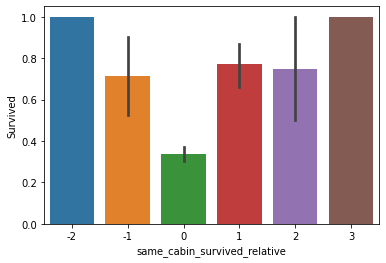

In [ ]:
sns.barplot(train_df["same_cabin_survived_relative"], train_df["Survived"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '1 Mr male 3'),
 Text(0, 0, '0 Mrs female 1'),
 Text(0, 0, '1 Miss female 3'),
 Text(0, 0, '0 Mr male 1'),
 Text(0, 0, '1 Master male 3'),
 Text(0, 0, '1 Mrs female 3'),
 Text(0, 0, '1 Mrs female 2'),
 Text(0, 0, '0 Miss female 3'),
 Text(0, 0, '0 Miss female 1'),
 Text(0, 0, '1 Mr male 2'),
 Text(0, 0, '0 Mr male 2'),
 Text(0, 0, '1 Rare male 1'),
 Text(0, 0, '1 Mr male 1'),
 Text(0, 0, '1 Miss female 2'),
 Text(0, 0, '0 Mrs female 2'),
 Text(0, 0, '0 Mr male 3'),
 Text(0, 0, '1 Master male 2'),
 Text(0, 0, '0 Miss female 2'),
 Text(0, 0, '1 Rare male 2'),
 Text(0, 0, '0 Master male 2'),
 Text(0, 0, '0 Rare male 1'),
 Text(0, 0, '0 Mrs female 3'),
 Text(0, 0, '1 Mrs female 1'),
 Text(0, 0, '1 Miss female 1'),
 Text(0, 0, '0 Master male 1'),
 Text(0, 0, '0 Rare female 1'),
 Text(0, 0, '1 Rare female 2'),
 Text(0, 0, '0 Master male 3')]

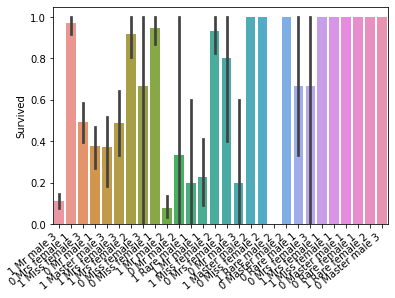

In [ ]:
ax = sns.barplot(train_df["same_cabin_died"].astype("string") + " " + train_df["Title + sex + Pclass"], train_df["Survived"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha = "right")


# Modeling

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier


In [ ]:
train_df.isna().sum()

Survived          0
Age               0
SibSp             0
Fare              0
family_members    0
                 ..
Title__Master     0
Title__Miss       0
Title__Mr         0
Title__Mrs        0
Title__Rare       0
Length: 949, dtype: int64

In [ ]:
y = train_df.pop("Survived")
X = train_df

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)

In [ ]:

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier()
RDF = RandomForestClassifier()
GBC = GradientBoostingClassifier()
BC = BaggingClassifier()
SVM = SVC()

classifiers = [DTC, ABC, RDF, GBC, BC, SVM]
names = ["DTC", "ABC", "RDF", "GBC", "BC", "SVM"]

In [ ]:
test_df

,Survived,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Last_name__Abbing,Last_name__Abbott,Last_name__Abelseth,Last_name__Abelson,Last_name__Abrahamsson,Last_name__Abrahim,Last_name__Adahl,Last_name__Adams,Last_name__Ahlin,Last_name__Aks,Last_name__Albimona,Last_name__Aldworth,Last_name__Alexander,Last_name__Alhomaki,Last_name__Ali,Last_name__Allen,Last_name__Allison,Last_name__Allum,Last_name__Andersen,Last_name__Andersen-Jensen,Last_name__Anderson,Last_name__Andersson,Last_name__Andreasson,Last_name__Andrew,Last_name__Andrews,Last_name__Angheloff,Last_name__Angle,Last_name__Appleton,Last_name__Arnold-Franchi,Last_name__Aronsson,Last_name__Artagaveytia,...,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3,Sex__female,Sex__male,Pclass__1,Pclass__2,Pclass__3,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
891,NaN,34.5,0,7.8292,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
892,NaN,47.0,1,7.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
893,NaN,62.0,0,9.6875,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
894,NaN,27.0,0,8.6625,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
895,NaN,22.0,1,12.2875,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,30.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1305,NaN,39.0,0,108.9000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1306,NaN,38.5,0,7.2500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1307,NaN,30.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [ ]:
test_df_final = pd.read_csv("/content/sample_data/test.csv")

In [ ]:
def make_predictions(classifier, name):
  if "Survived" in test_df.columns:
    test_df.pop("Survived")
  classifier.fit(X,y)
  predictions = pd.concat( [test_df_final["PassengerId"], pd.DataFrame(classifier.predict(test_df))], axis = 1)
  predictions.columns = ["PassengerId", "Survived"]
  predictions["Survived"] = predictions["Survived"].astype(int)
  predictions.to_csv(f"predictions_titanic2_{name}.csv", index = False)

for classifier, name in zip(classifiers, names):
  make_predictions(classifier, name)


In [ ]:
for classifier in classifiers:
  # classifier.fit(Xtrain,ytrain)
  CVS = cross_val_score(classifier, X, y)
  print(CVS, np.mean(CVS))

[0.81460674 0.79775281 0.87640449 0.81460674 0.84831461] 0.8303370786516853
[0.75842697 0.80898876 0.83146067 0.83146067 0.84831461] 0.8157303370786517
[0.81460674 0.80337079 0.85393258 0.82022472 0.85955056] 0.8303370786516855
[0.8258427  0.82022472 0.8258427  0.80898876 0.83146067] 0.8224719101123595
[0.83146067 0.82022472 0.85393258 0.8258427  0.86516854] 0.8393258426966292
[0.58988764 0.71348315 0.69662921 0.67977528 0.69101124] 0.6741573033707866


In [ ]:
def test(classifier):
  if "Survived" in test_df.columns:
    test_df.pop("Survived")
  classifier.fit(X,y)
  print("predicted ratio of survival train",classifier.predict(train_df).sum()/len(train_df))
  print("predicted ratio of survival test", classifier.predict(test_df).sum()/len(test_df))
  print()

In [ ]:

for classifier in classifiers:
  test(classifier)

predicted ratio of survival train 0.3842696629213483
predicted ratio of survival test 0.38995215311004783

predicted ratio of survival train 0.3651685393258427
predicted ratio of survival test 0.3923444976076555

predicted ratio of survival train 0.3842696629213483
predicted ratio of survival test 0.3588516746411483

predicted ratio of survival train 0.3393258426966292
predicted ratio of survival test 0.36363636363636365

predicted ratio of survival train 0.36741573033707864
predicted ratio of survival test 0.33253588516746413

predicted ratio of survival train 0.1662921348314607
predicted ratio of survival test 0.18181818181818182



In [ ]:
GBC.fit(X,y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
if "Survived" in test_df.columns:
    test_df.pop("Survived")

In [ ]:
GBC.predict(train_df).sum()/len(train_df)

0.34269662921348315

In [ ]:
GBC.predict(test_df).sum()/len(test_df)

0.361244019138756

In [ ]:
test_df.isna().sum()

Age               0
SibSp             0
Fare              0
family_members    0
Is_Baby           0
                 ..
Title__Master     0
Title__Miss       0
Title__Mr         0
Title__Mrs        0
Title__Rare       0
Length: 948, dtype: int64

# Tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
X

,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Last_name__Abbing,Last_name__Abbott,Last_name__Abelseth,Last_name__Abelson,Last_name__Abrahamsson,Last_name__Abrahim,Last_name__Adahl,Last_name__Adams,Last_name__Ahlin,Last_name__Aks,Last_name__Albimona,Last_name__Aldworth,Last_name__Alexander,Last_name__Alhomaki,Last_name__Ali,Last_name__Allen,Last_name__Allison,Last_name__Allum,Last_name__Andersen,Last_name__Andersen-Jensen,Last_name__Anderson,Last_name__Andersson,Last_name__Andreasson,Last_name__Andrew,Last_name__Andrews,Last_name__Angheloff,Last_name__Angle,Last_name__Appleton,Last_name__Arnold-Franchi,Last_name__Aronsson,Last_name__Artagaveytia,Last_name__Ashby,...,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3,Sex__female,Sex__male,Pclass__1,Pclass__2,Pclass__3,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
0,22.0,1,7.2500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,38.0,1,71.2833,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,35.0,1,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,35.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,13.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
887,19.0,0,30.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
888,30.0,1,23.4500,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
889,26.0,0,30.0000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((Xtest, ytest)).batch(32)
if "Survived" in test_df.columns:
  test_df.drop("Survived", inplace = True)
test_ds = tf.data.Dataset.from_tensor_slices(test_df).batch(32)
full_train_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)

In [ ]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 890, dtype: float64

In [ ]:
Xtest

,Age,SibSp,Fare,family_members,Is_Baby,Embarked__C,Embarked__Q,Embarked__S,Last_name__Abbing,Last_name__Abbott,Last_name__Abelseth,Last_name__Abelson,Last_name__Abrahamsson,Last_name__Abrahim,Last_name__Adahl,Last_name__Adams,Last_name__Ahlin,Last_name__Aks,Last_name__Albimona,Last_name__Aldworth,Last_name__Alexander,Last_name__Alhomaki,Last_name__Ali,Last_name__Allen,Last_name__Allison,Last_name__Allum,Last_name__Andersen,Last_name__Andersen-Jensen,Last_name__Anderson,Last_name__Andersson,Last_name__Andreasson,Last_name__Andrew,Last_name__Andrews,Last_name__Angheloff,Last_name__Angle,Last_name__Appleton,Last_name__Arnold-Franchi,Last_name__Aronsson,Last_name__Artagaveytia,Last_name__Ashby,...,Cabin_letter__0,Cabin_letter__A,Cabin_letter__B,Cabin_letter__C,Cabin_letter__D,Cabin_letter__E,Cabin_letter__F,Cabin_letter__G,Cabin_letter__T,"Fare_binned__(0, 10]","Fare_binned__(10, 50]","Fare_binned__(50, 80]","Fare_binned__(80, 1900]",same_last_name_survived_relative__-7,same_last_name_survived_relative__-6,same_last_name_survived_relative__-5,same_last_name_survived_relative__-4,same_last_name_survived_relative__-3,same_last_name_survived_relative__-2,same_last_name_survived_relative__-1,same_last_name_survived_relative__0,same_last_name_survived_relative__1,same_last_name_survived_relative__2,same_last_name_survived_relative__3,same_cabin_survived_relative__-2,same_cabin_survived_relative__-1,same_cabin_survived_relative__0,same_cabin_survived_relative__1,same_cabin_survived_relative__2,same_cabin_survived_relative__3,Sex__female,Sex__male,Pclass__1,Pclass__2,Pclass__3,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
153,40.5,0,14.5000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
507,30.0,0,26.5500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0
638,41.0,0,39.6875,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
427,19.0,0,26.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
488,30.0,0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,11.0,0,18.7875,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
347,30.0,1,16.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
763,36.0,1,120.0000,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0
302,19.0,0,0.0000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(1000, activation = "relu" ),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(500, activation = "relu"),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(100, activation = "relu"),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation = "sigmoid"),
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_ds, batch_size = 32, epochs = 20, validation_data=val_ds, callbacks=[callback])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


21/21 [==============================] - 1s 26ms/step - loss: 0.9813 - accuracy: 0.6192 - val_loss: 0.5896 - val_accuracy: 0.7085
Epoch 2/20
21/21 [==============================] - 0s 19ms/step - loss: 0.6649 - accuracy: 0.6612 - val_loss: 0.5819 - val_accuracy: 0.7085
Epoch 3/20
21/21 [==============================] - 0s 20ms/step - loss: 0.6221 - accuracy: 0.6807 - val_loss: 0.5713 - val_accuracy: 0.6996
Epoch 4/20
21/21 [==============================] - 0s 20ms/step - loss: 0.5801 - accuracy: 0.6882 - val_loss: 0.5486 - val_accuracy: 0.7175
Epoch 5/20
21/21 [==============================] - 0s 21ms/step - loss: 0.5722 - accuracy: 0.7151 - val_loss: 0.5210 - val_accuracy: 0.7713
Epoch 6/20
21/21 [==============================] - 0s 21ms/step - loss: 0.5486 - accuracy: 0.7256 - val_loss: 0.4906 - val_accuracy: 0.7848
Epoch 7/20
21/21 [==============================] - 0s 20ms/step - loss: 0.5142 - accuracy: 0.7826 - val_loss: 0.4758 - val_accuracy: 0.7848
Epoch 8/20
21/21 [======

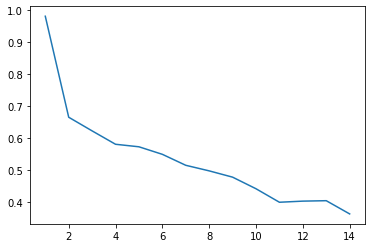

In [ ]:
sns.lineplot(x = np.arange(1,15), y = history.history["loss"])

In [ ]:
model.fit(train_ds, batch_size = 32, epochs = 20, validation_data = val_ds)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


21/21 [==============================] - 1s 11ms/step - loss: 0.7518 - accuracy: 0.6147 - val_loss: 0.6865 - val_accuracy: 0.6906
Epoch 2/20
21/21 [==============================] - 0s 5ms/step - loss: 0.7074 - accuracy: 0.6777 - val_loss: 0.6329 - val_accuracy: 0.6771
Epoch 3/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6572 - accuracy: 0.6762 - val_loss: 0.6116 - val_accuracy: 0.7040
Epoch 4/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6044 - accuracy: 0.7031 - val_loss: 0.5932 - val_accuracy: 0.7085
Epoch 5/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6076 - accuracy: 0.7106 - val_loss: 0.5695 - val_accuracy: 0.7309
Epoch 6/20
21/21 [==============================] - 0s 5ms/step - loss: 0.5824 - accuracy: 0.7076 - val_loss: 0.5405 - val_accuracy: 0.7848
Epoch 7/20
21/21 [==============================] - 0s 5ms/step - loss: 0.5345 - accuracy: 0.7601 - val_loss: 0.5145 - val_accuracy: 0.7848
Epoch 8/20
21/21 [============

In [ ]:
predictions = pd.DataFrame(model.predict_classes(test_ds))
predictions = pd.concat( [test_df_final["PassengerId"], pd.DataFrame(model.predict_classes(test_ds))], axis = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions

,PassengerId,0
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
def make_predictions_tensorflow(model, name):
  if "Survived" in test_df.columns:
    test_df.pop("Survived")
  model.fit(full_train_ds, batch_size = 32, epochs = 20, callbacks = [callback])
  predictions = pd.concat( [test_df_final["PassengerId"], pd.DataFrame(model.predict_classes(test_ds))], axis = 1)  
  predictions.columns = ["PassengerId", "Survived"]
  predictions["Survived"] = predictions["Survived"].astype(int)
  predictions.to_csv(f"predictions_titanic2_tensorflow{name}.csv", index = False)